## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [4]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

/home/k64835/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/k64835/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

Dictionary for subpatch-to-patch mapping of reconstructed images

In [6]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [7]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

### Create Sub-Patches

In [8]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 10, 4, 4]), torch.Size([1197, 7, 10, 4, 4]))

Get field numbers and co-ordinates as string

In [9]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167136.0_1167138.0_24_24'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [10]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Architecture 1: Conv3D Autoencoder

### Architecture

Input Data: ( N x C x D x H x W )

In [124]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [133]:
device = 'cuda'
epochs = 50
lr = 0.01
momentum = 0.9
latent_dim = 32
channels = 10
time_steps = 7
optimizer = 'SGD'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [134]:
trained_model, train_losses, test_losses = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 6.1989 seconds
Epoch 1/50, Train Loss: 0.008207, Test Loss: 0.003779
Time taken per epoch: 6.1071 seconds
Epoch 2/50, Train Loss: 0.003556, Test Loss: 0.003430
Time taken per epoch: 6.2107 seconds
Epoch 3/50, Train Loss: 0.003365, Test Loss: 0.003327
Time taken per epoch: 6.1236 seconds
Epoch 4/50, Train Loss: 0.003299, Test Loss: 0.003275
Time taken per epoch: 6.0807 seconds
Epoch 5/50, Train Loss: 0.003251, Test Loss: 0.003242
Time taken per epoch: 6.1025 seconds
Epoch 6/50, Train Loss: 0.003222, Test Loss: 0.003221
Time taken per epoch: 6.1048 seconds
Epoch 7/50, Train Loss: 0.003205, Test Loss: 0.003205
Time taken per epoch: 6.1242 seconds
Epoch 8/50, Train Loss: 0.003191, Test Loss: 0.003194
Time taken per epoch: 6.1293 seconds
Epoch 9/50, Train Loss: 0.003187, Test Loss: 0.003187
Time taken per epoch: 6.1380 seconds
Epoch 10/50, Train Loss: 0.003174, Test Loss: 0.003179
Time taken per epoch: 6.0729 seconds
Epoch 11/50, Train Loss: 0.003168, Test Loss: 0.0031

### Evaluation

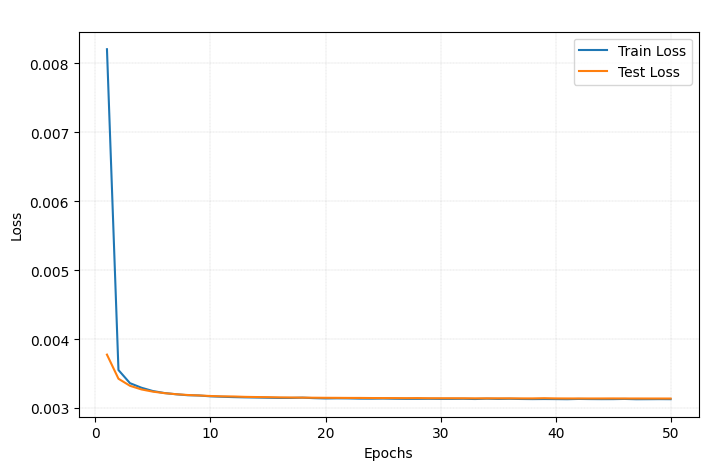

In [135]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training

In [136]:
# with open(config.kmeans_ae_3D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [137]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [138]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [139]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=21)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [140]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 62.3
Precision: 63.04
Recall: 82.86
F1-score: 71.6
F2-score: 77.96


Save Models

In [141]:
# with open(config.ae_3d_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [142]:
# with open(config.kmeans_ae_3D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

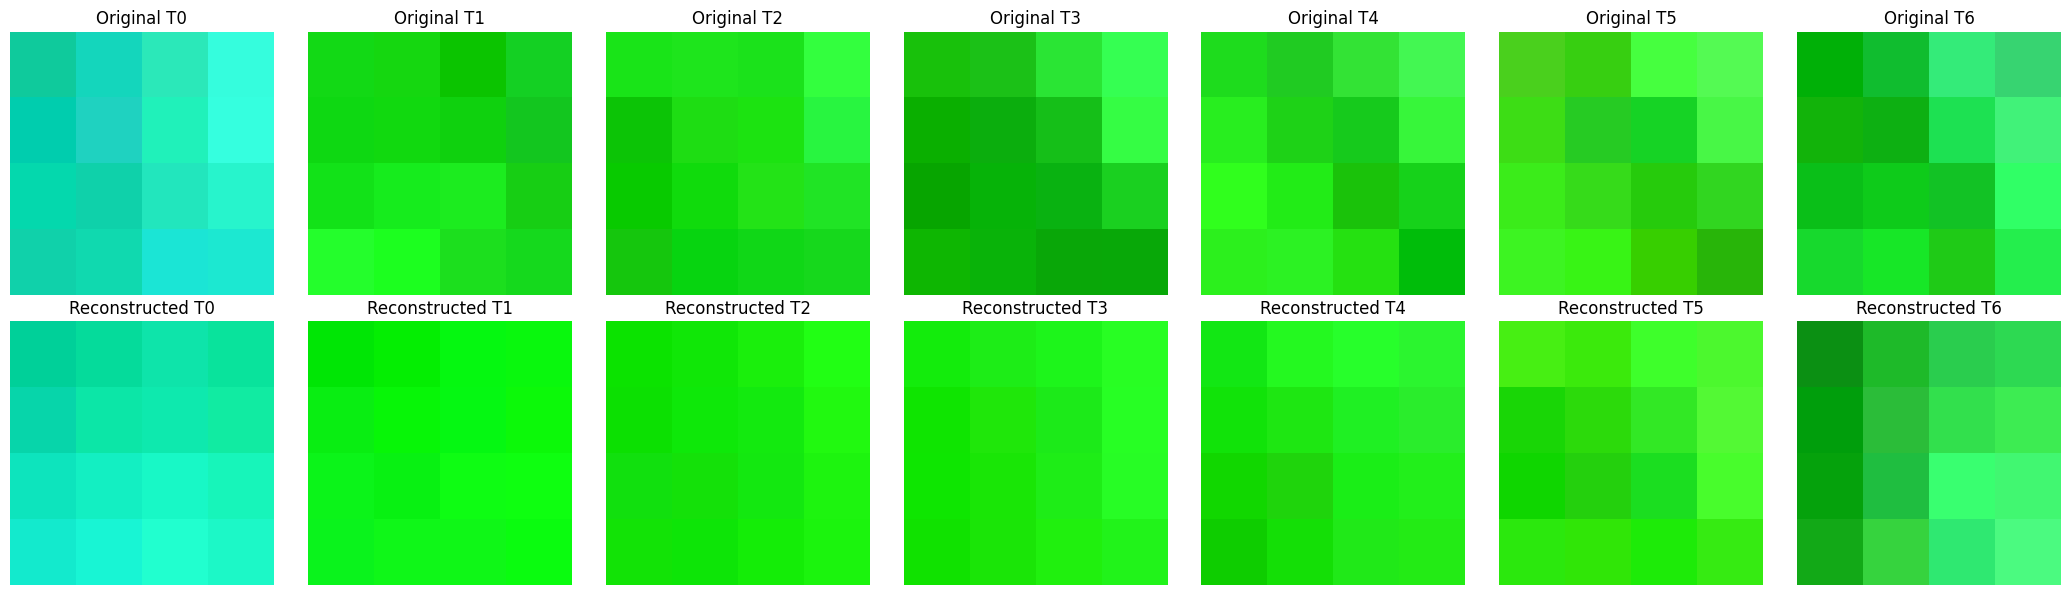

In [27]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

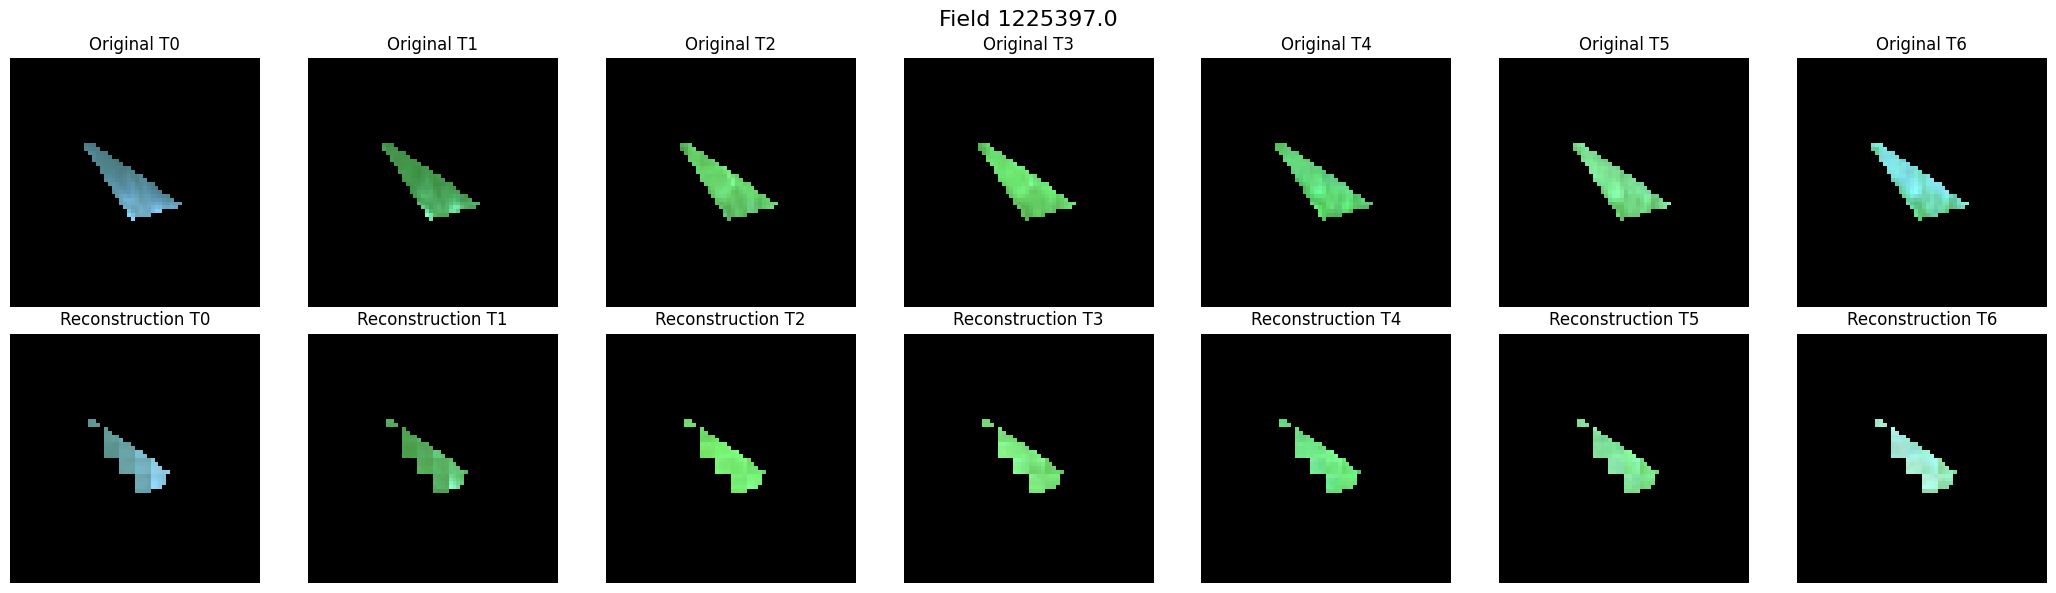

In [29]:
plot_reconstructed_patches_temporal(trained_model,dataloader_eval,old_images_eval, 1, device)

## Architecture 2: Conv2D Autoencoder with Time steps (7) as Channels

### Architecture

In [143]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed

### Training

In [144]:
device = 'cuda'
epochs = 50
lr = 0.01
latent_dim=32
channels = 10
optimizer = 'SGD'
momentum = 0.9
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoder(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [145]:
trained_model, train_losses, test_losses = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 1.8972 seconds
Epoch 1/50, Train Loss: 0.025001, Test Loss: 0.005464
Time taken per epoch: 2.0798 seconds
Epoch 2/50, Train Loss: 0.004997, Test Loss: 0.004629
Time taken per epoch: 2.1503 seconds
Epoch 3/50, Train Loss: 0.004358, Test Loss: 0.004135
Time taken per epoch: 2.2473 seconds
Epoch 4/50, Train Loss: 0.003954, Test Loss: 0.003807
Time taken per epoch: 2.1532 seconds
Epoch 5/50, Train Loss: 0.003684, Test Loss: 0.003586
Time taken per epoch: 2.0928 seconds
Epoch 6/50, Train Loss: 0.003498, Test Loss: 0.003440
Time taken per epoch: 2.2442 seconds
Epoch 7/50, Train Loss: 0.003380, Test Loss: 0.003347
Time taken per epoch: 2.1224 seconds
Epoch 8/50, Train Loss: 0.003308, Test Loss: 0.003289
Time taken per epoch: 2.0929 seconds
Epoch 9/50, Train Loss: 0.003261, Test Loss: 0.003255
Time taken per epoch: 2.0788 seconds
Epoch 10/50, Train Loss: 0.003233, Test Loss: 0.003233
Time taken per epoch: 2.1764 seconds
Epoch 11/50, Train Loss: 0.003221, Test Loss: 0.0032

### Evaluation

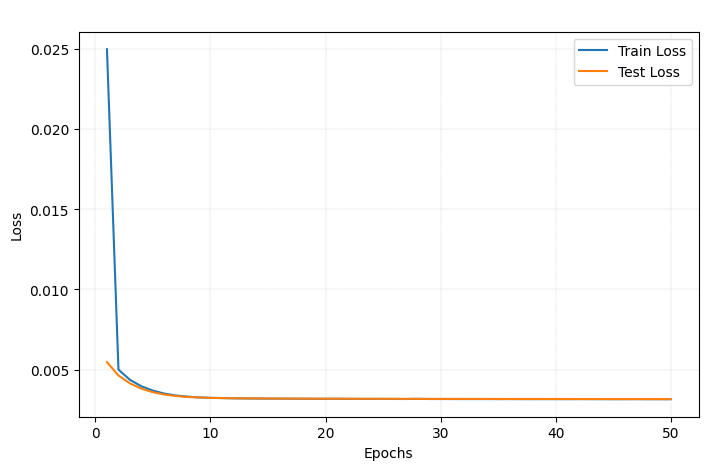

In [146]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

In [147]:
# with open(config.kmeans_ae_2D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [148]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_2D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [149]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [150]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=22)    # Skip this when loading saved model

In [151]:
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [152]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 65.57
Precision: 73.33
Recall: 62.86
F1-score: 67.69
F2-score: 64.71


Save Models

In [153]:
# with open(config.ae_2D_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [154]:
# with open(config.kmeans_ae_2D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

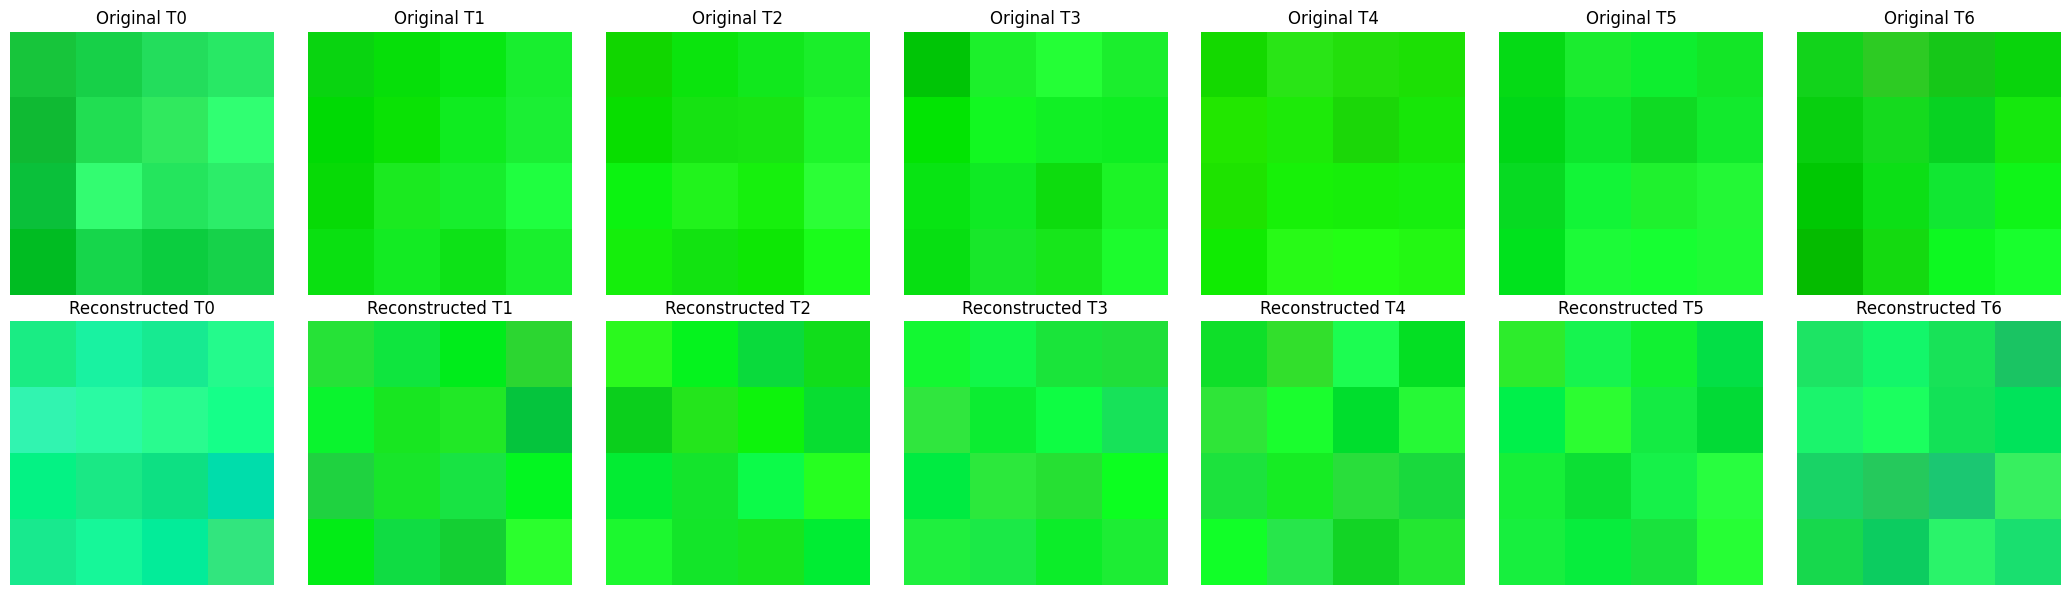

In [59]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions

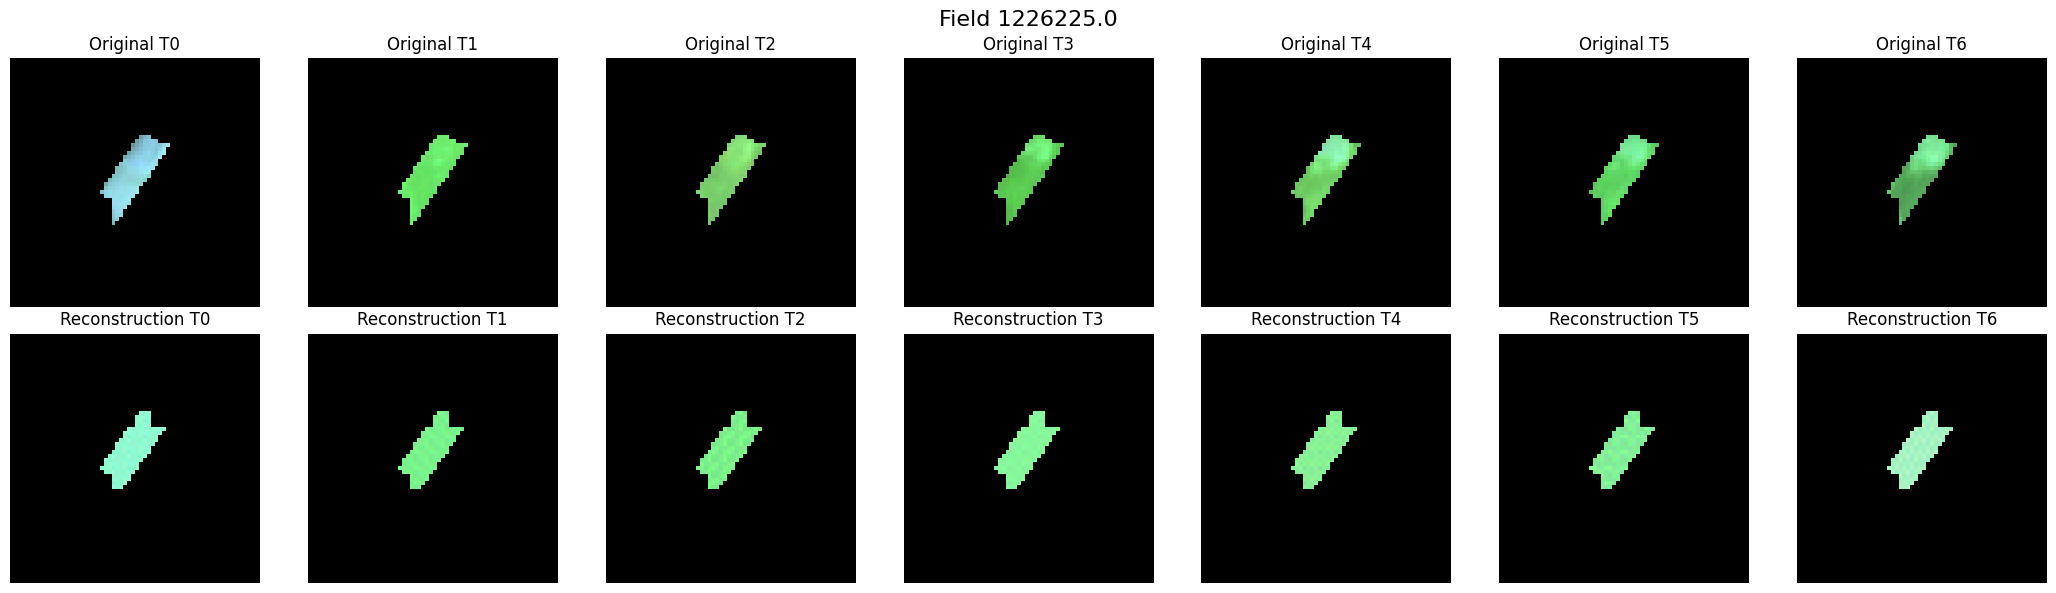

In [124]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device)

## Architecture 3: Conv3D Variationl Autoencoder

### Architecture

In [60]:
class Conv3DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * time_steps * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)
        self.fc_logvar = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * time_steps * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape for 3D Deconvolutions ---
        x = self.unflatten(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return mu, log_var, z, x_reconstructed


### Training

In [61]:
device = 'cuda'
epochs = 50
lr = 0.0001
optimizer = 'Adam'
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [62]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 417.5228, Train KL Loss: 1.6836
  Test Recon Loss: 238.7879, Test KL Loss: 8.0978
Epoch 2/50
  Train Recon Loss: 174.1134, Train KL Loss: 18.0282
  Test Recon Loss: 150.1573, Test KL Loss: 20.9233
Epoch 3/50
  Train Recon Loss: 104.6336, Train KL Loss: 22.1998
  Test Recon Loss: 92.0261, Test KL Loss: 20.7585
Epoch 4/50
  Train Recon Loss: 87.0527, Train KL Loss: 20.7439
  Test Recon Loss: 80.1714, Test KL Loss: 20.3997
Epoch 5/50
  Train Recon Loss: 75.3286, Train KL Loss: 20.4544
  Test Recon Loss: 69.7304, Test KL Loss: 20.4921
Epoch 6/50
  Train Recon Loss: 62.4981, Train KL Loss: 21.2045
  Test Recon Loss: 65.8483, Test KL Loss: 21.4904
Epoch 7/50
  Train Recon Loss: 51.5334, Train KL Loss: 21.5458
  Test Recon Loss: 52.0117, Test KL Loss: 20.5976
Epoch 8/50
  Train Recon Loss: 47.5326, Train KL Loss: 20.8971
  Test Recon Loss: 46.5312, Test KL Loss: 20.4889
Epoch 9/50
  Train Recon Loss: 43.8517, Train KL Loss: 20.3629
  Test Recon Loss: 46.3479, Te

### Evaluation

In [5]:
plot_loss(train_recon_losses, test_recon_losses, " ")

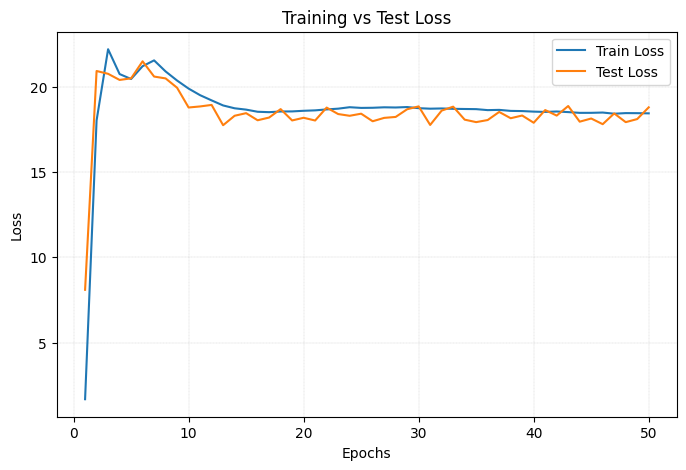

In [64]:
plot_loss(train_kl_losses, test_kl_losses)

##### NOTE: Load Saved Model to skip Training the model

In [65]:
# with open(config.kmeans_vae_3D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [144]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.vae_3D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [66]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [ ]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=24)   #skip this if loading saved model

In [70]:
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [71]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 55.74
Precision: 61.11
Recall: 62.86
F1-score: 61.97
F2-score: 62.5


Save Models

In [74]:
# with open(config.vae_3D_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [75]:
# with open(config.kmeans_vae_3D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

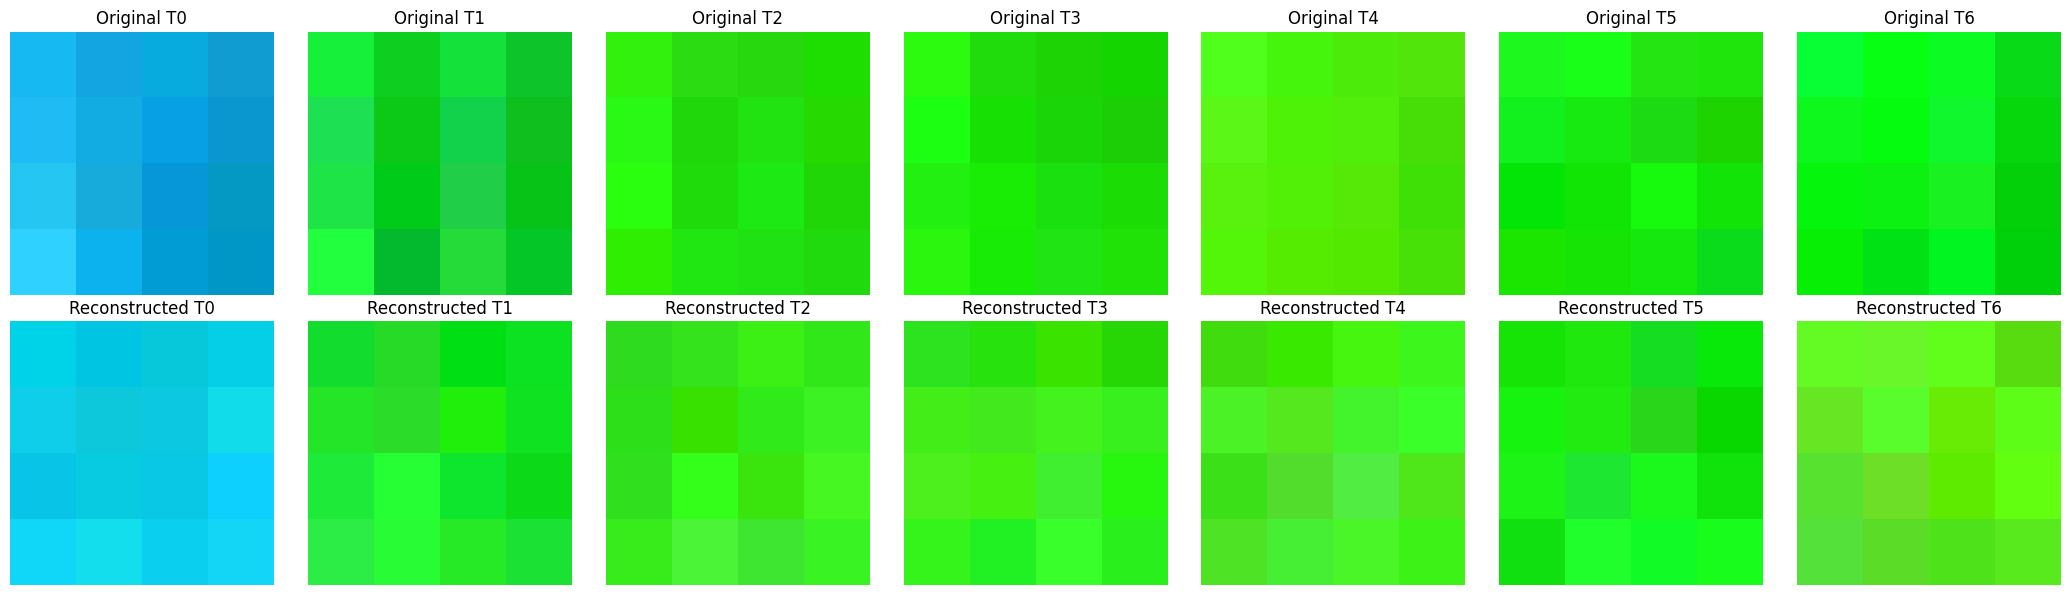

In [153]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_eval, 1, device, model_type='vae')

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

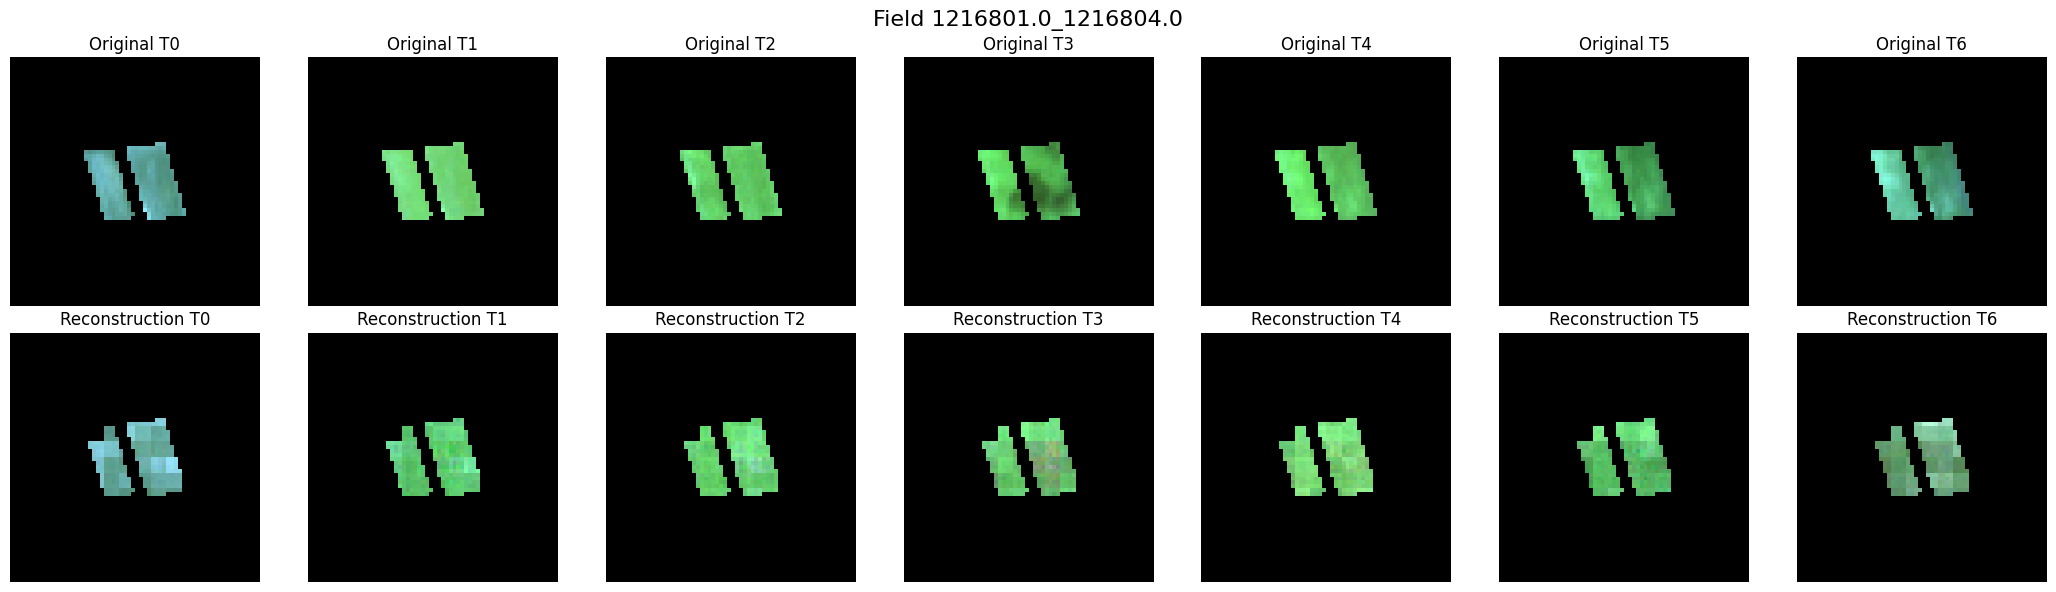

In [82]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device, model_type='vae')

## Architecture 4: Conv2D Variational Autoencoder

### Architecture

In [83]:
class Conv2DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)      # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as channels (B, C * T, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return mu, log_var, z, x_reconstructed

### Training

In [84]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
optimizer='Adam'
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DVAE(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [85]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 314.8256, Train KL Loss: 1.9571
  Test Recon Loss: 209.7239, Test KL Loss: 3.3312
Epoch 2/50
  Train Recon Loss: 188.4840, Train KL Loss: 4.3021
  Test Recon Loss: 185.1100, Test KL Loss: 3.8231
Epoch 3/50
  Train Recon Loss: 175.9745, Train KL Loss: 3.1144
  Test Recon Loss: 176.0811, Test KL Loss: 3.0148
Epoch 4/50
  Train Recon Loss: 156.5434, Train KL Loss: 4.6304
  Test Recon Loss: 139.6453, Test KL Loss: 5.6988
Epoch 5/50
  Train Recon Loss: 131.1432, Train KL Loss: 5.6793
  Test Recon Loss: 126.6813, Test KL Loss: 7.7456
Epoch 6/50
  Train Recon Loss: 108.1796, Train KL Loss: 7.7364
  Test Recon Loss: 105.8675, Test KL Loss: 7.2803
Epoch 7/50
  Train Recon Loss: 91.6741, Train KL Loss: 8.8689
  Test Recon Loss: 88.8210, Test KL Loss: 9.3912
Epoch 8/50
  Train Recon Loss: 76.4914, Train KL Loss: 10.5272
  Test Recon Loss: 70.8744, Test KL Loss: 11.3455
Epoch 9/50
  Train Recon Loss: 63.9954, Train KL Loss: 11.1420
  Test Recon Loss: 66.9466, Test KL

### Evaluation

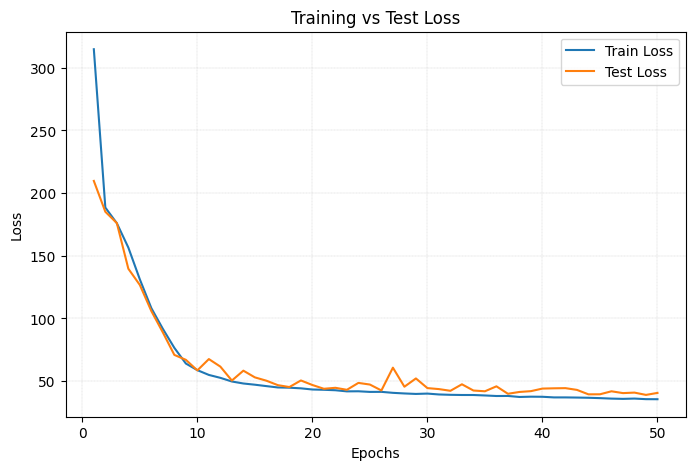

In [86]:
plot_loss(train_recon_losses, test_recon_losses)

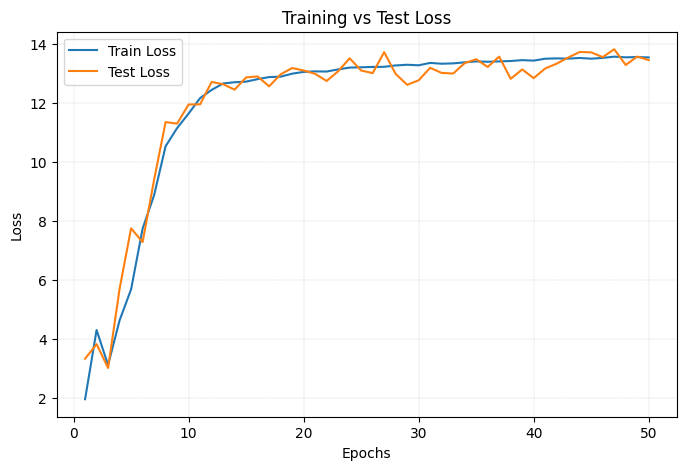

In [87]:
plot_loss(train_kl_losses, test_kl_losses)

##### NOTE: Load Saved Model to skip Training the model

In [88]:
# with open(config.kmeans_vae_2D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [89]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.vae_2D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [101]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [ ]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=25) #skip when loading the saved model

In [102]:
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [103]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 55.74
Precision: 61.76
Recall: 60.0
F1-score: 60.87
F2-score: 60.34


Save Models

In [104]:
# with open(config.vae_2D_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [105]:
# with open(config.kmeans_vae_2D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

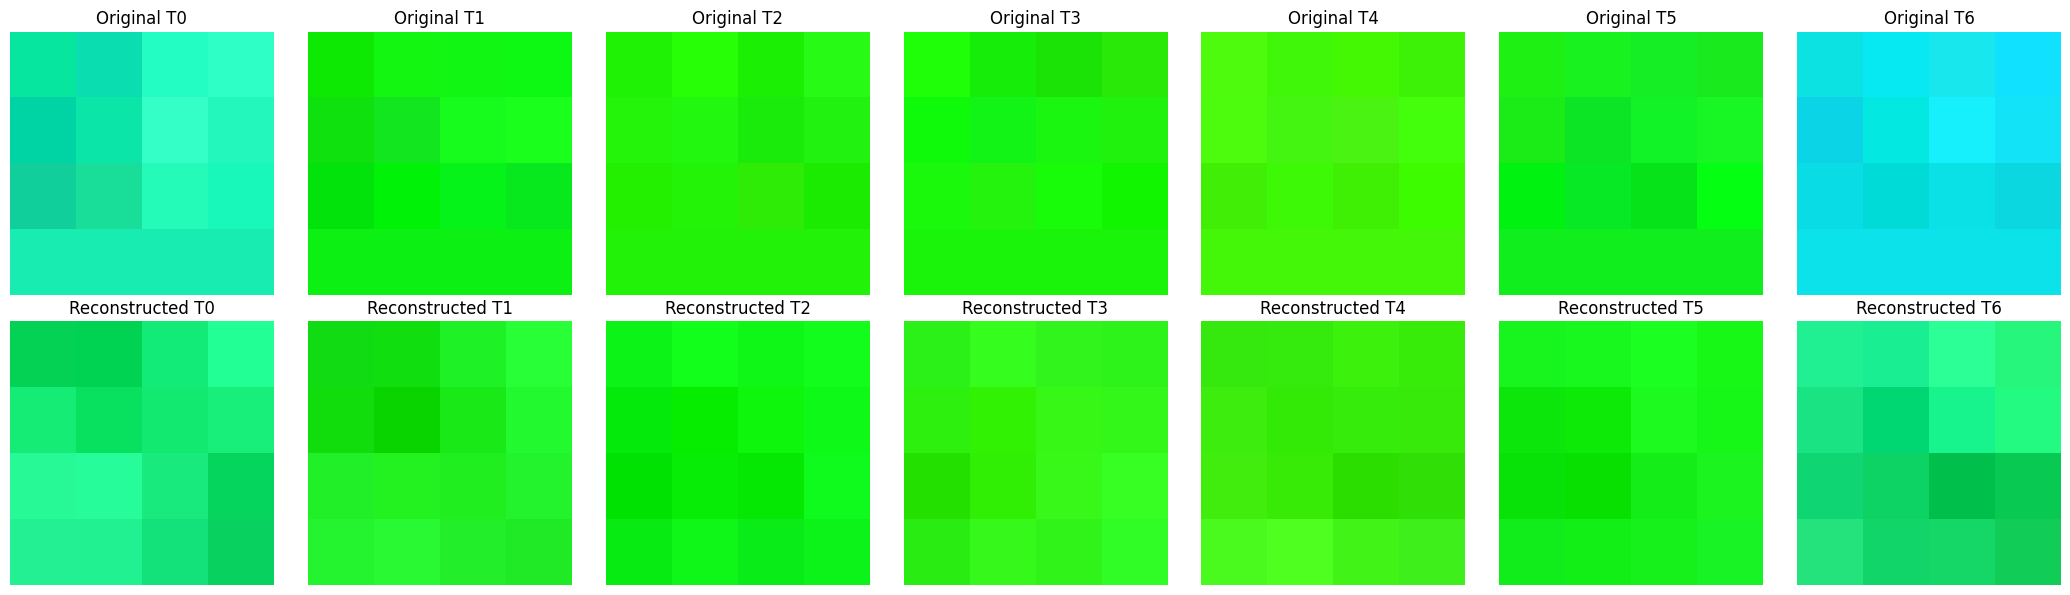

In [182]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_eval, 1, device, model_type='vae')

Map subpatch-level to patches and Visualise Patch level reconstructions

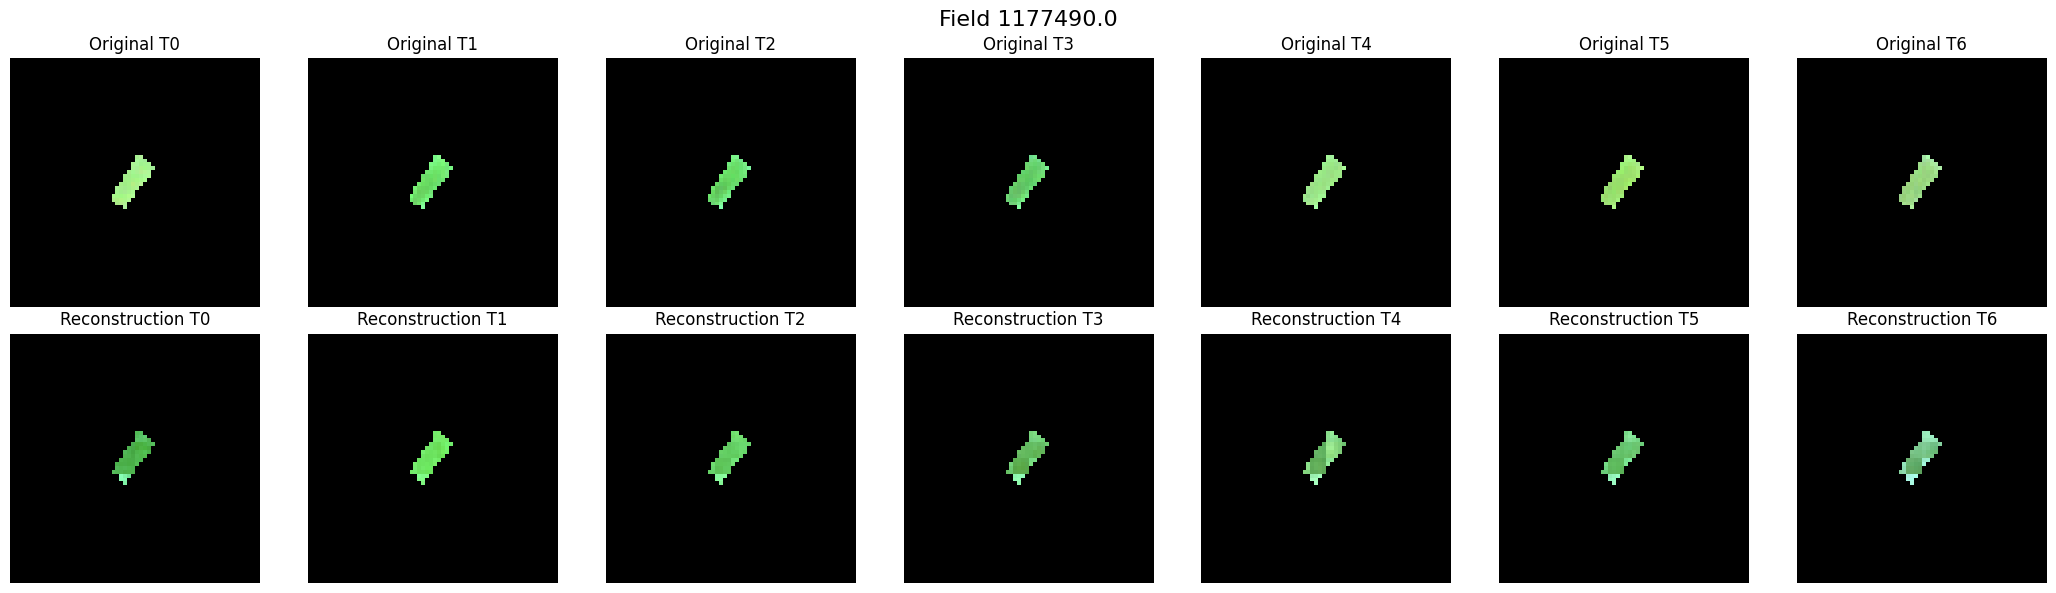

In [112]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device, model_type='vae')